# Carry

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# Expected Returns

To manage a portfolio, we must measure **expected returns**.

### Risk

Most popular measures of risk...
* require little modeling (volatility, max drawdown)
* are statistically precise (volatilityl, beta)

### Optimal portfolios

Optimizing mean vs variance requires a measurement of each asset's expected return.
* sample average is a noisy estimate
* backward looking

### Expected return

The expected return is defined for some horizon, $h$. 

$$E\left[r_{t+h}\right]$$

It may be formed from...
* historic average
* analyst views
* forecasting via market / economic signals

There are a few common statistical approaches to expected returns
* carry
* value
* momentum
* factors

***

# FX Carry

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               StrMethodFormatter,
                               AutoMinorLocator)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from portfolio import *

$$\newcommand{\frn}{*}$$

$$\newcommand{\RF}{R^{f,\$}}$$
$$\newcommand{\RFa}{R^{f,\frn}}$$

$$\newcommand{\rflog}{\texttt{r}^{f,\$}}$$
$$\newcommand{\rfalog}{\texttt{r}^{f,\frn}}$$

$$\newcommand{\Fcrncy}{F^{\$}}$$
$$\newcommand{\fcrncylog}{\texttt{f}^{\$}}$$

$$\newcommand{\FX}{S}$$
$$\newcommand{\fxlog}{\texttt{s}}$$

# Currency

Currency is traded on the **spot** market at the **exchange rate**.

## Derivatives

Currency derivatives include, (in descending order of size/importance)
* forwards
* swaps
* futures
* options

A few notes on the sizes here...
* Forward currency market is larger than interest-rate forwards!
* Swaps market for currency is about 10% the size of interest-rate swaps.
* Currency options are relatively small, yet still about 1/3 the size of equity options!

### Notable Features
* FX markets are smaller than rates markets, but still huge.
* FX trades mostly in spot, forwards, and swaps
* Relatively small amount in options or futures

### References
OTC Derivatives Size

https://stats.bis.org/statx/srs/table/d5.1

Futures Markets Size

https://stats.bis.org/statx/srs/table/d1

Trading Turnover

https://stats.bis.org/statx/srs/table/d11.1

# Data

`fx_carry_data.xlsx`.

## Risk-free rates
It reports the risk-free rates for various currencies.
- The data is defined such that the March value of the risk-free rate corresponds to the rate beginning in March and ending in April.
- In terms of the class notation, $r^{f,i}_{t,t+1}$ is reported at time $t$. (It is risk-free, so it is a rate from $t$ to $t+1$ but it is know at $t$.

## Exchange rates
Spot exchange rates.

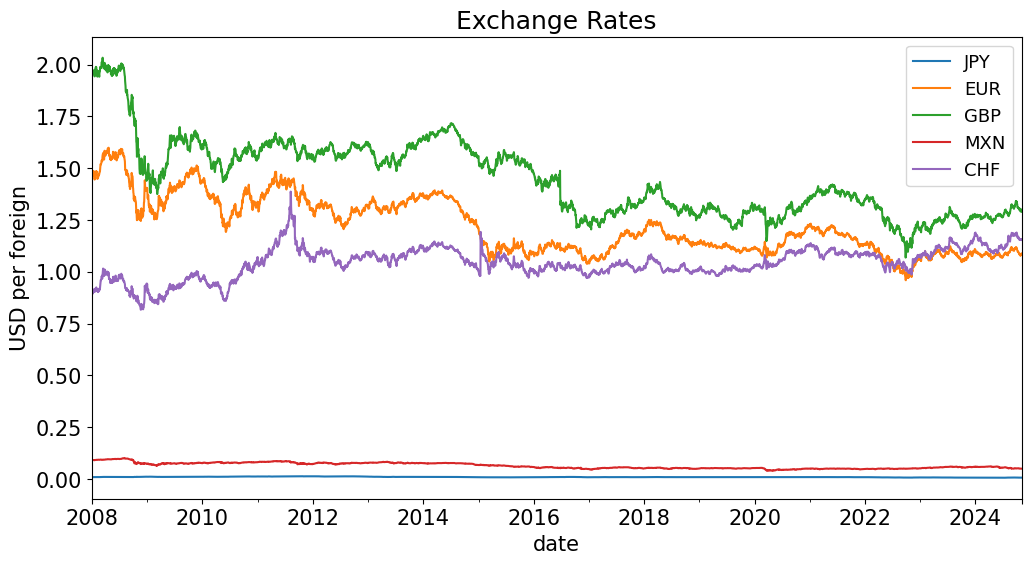

In [2]:
DATAPATH_FX = '../data/fx_rf_data.xlsx'
SHEET = 'exchange rates'

fxraw = pd.read_excel(DATAPATH_FX, sheet_name=SHEET).set_index('date')
fxraw.plot(title='Exchange Rates',ylabel='USD per foreign');

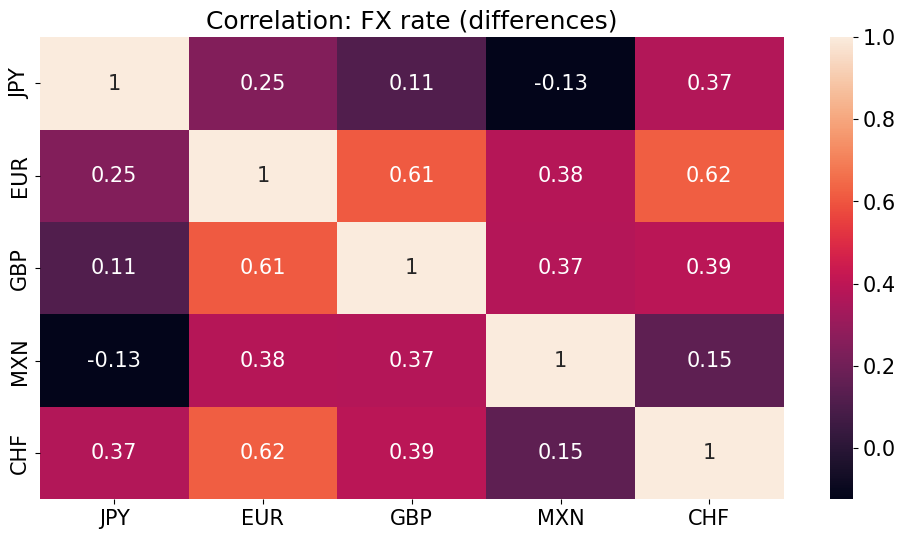

In [3]:
sns.heatmap(fxraw.diff().corr(),annot=True)
plt.title('Correlation: FX rate (differences)');

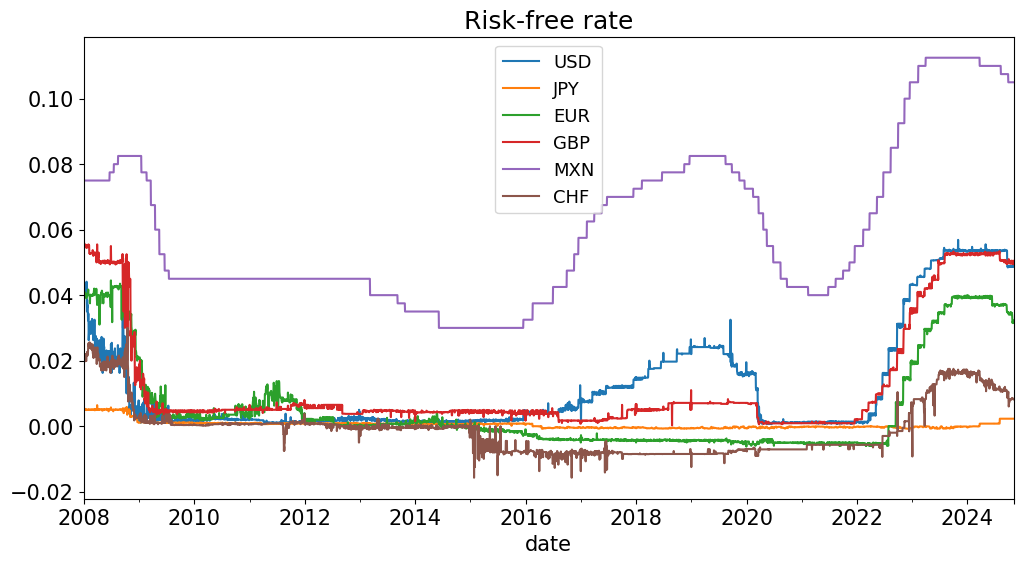

In [4]:
SHEET = 'risk-free rates'

rfraw = pd.read_excel(DATAPATH_FX,sheet_name=SHEET).set_index('date')
rfraw.plot(title='Risk-free rate');

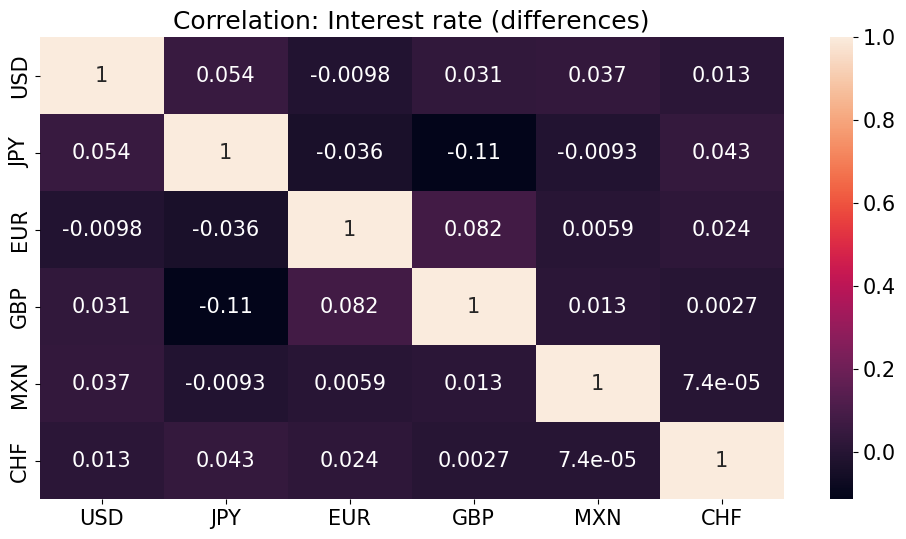

In [5]:
sns.heatmap(rfraw.diff().corr(),annot=True)
plt.title('Correlation: Interest rate (differences)');

<Axes: >

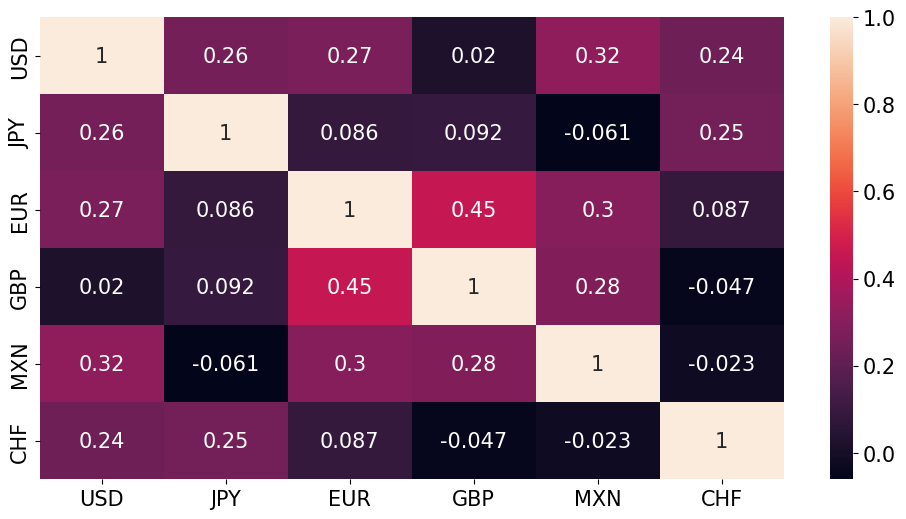

In [6]:
temp = rfraw.resample('ME').last()
sns.heatmap(temp.diff().corr(),annot=True)

# Returns

### Notation

* $S_t$ denotes the foreign exchange rate, expressed as USD per foreign currency
* $\RF_{t,t+1}$ denotes the risk-free factor on US dollars (USD).
* $\RFa_{t,t+1}$ denotes the risk-free factor on a particular foreign currency.

### Two components to returns

Misconception that the return on currency is the percentage change in the exchange rate:
$$\frac{S_{t+1}}{S_t}$$

The price of the currency is $S_t$ dollars.
* In terms of USD, the payoff at time t + 1 of the Euro riskless asset is 
$$\RFa_{t,t+1} S_{t+1}$$

That is, 
* we capitalize any FX gains, 
* but we also earn the riskless return accumulated by the foreign currency.

Thus, the USD return on holding Euros is given by,
$$\RFa_{t,t+1}\frac{ S_{t+1}}{S_t}$$

In [7]:
shared_indexes = rfraw.index.intersection(fxraw.index)

# Split the merged DataFrame back into the original two DataFrames with shared indexes
rf = rfraw.loc[shared_indexes,:]
fx = fxraw.loc[shared_indexes,:]

In [8]:
USDRF = 'USD'

DAYS = fx.resample('YE').size().median()
rf /= DAYS

rfusd = rf[[USDRF]]
rf = rf.drop(columns=[USDRF])

fxgrowth = (fx / fx.shift())
rets = fxgrowth.mul(1+rf.values,axis=1) - 1
rx = rets.sub(rfusd.values,axis=1)

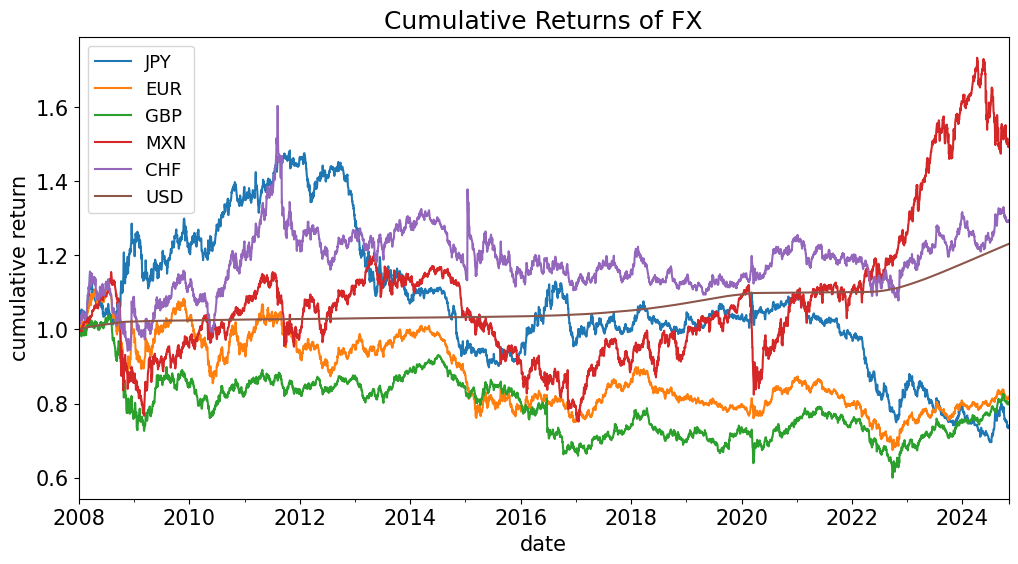

In [9]:
fig, ax = plt.subplots()
(1+rets).cumprod().plot(ax=ax)
(1+rfusd).cumprod().plot(ax=ax)
plt.title('Cumulative Returns of FX')
plt.ylabel('cumulative return')
plt.show()

### Extra Statistics on Returns

Main takeaway:
* small mean return--only exciting if you use leverage
* substantial volatility
* large drawdowns (tail-events)

In [10]:
performanceMetrics(rx,annualization=DAYS).style.format('{:.2%}')

,Mean,Vol,Sharpe,Min,Max
JPY,-2.51%,10.09%,-24.88%,-5.33%,3.91%
EUR,-2.00%,9.17%,-21.85%,-2.40%,3.51%
GBP,-2.10%,9.71%,-21.62%,-8.05%,3.15%
MXN,2.06%,13.19%,15.61%,-7.63%,6.90%
CHF,0.90%,11.09%,8.14%,-8.69%,21.52%


In [11]:
tailMetrics(rets)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
JPY,0.186281,5.329387,-0.009484,-0.014076,-0.530922,2011-10-28,2024-07-03,None,None
EUR,0.139694,2.404630,-0.008893,-0.012795,-0.395366,2008-07-11,2022-09-27,None,None
GBP,-0.722942,10.054525,-0.009255,-0.013866,-0.422246,2008-07-15,2022-09-26,None,None
MXN,-0.592604,7.366123,-0.012602,-0.019364,-0.377756,2013-05-08,2017-01-18,2022-10-25 00:00:00,None
CHF,6.742064,227.365595,-0.009138,-0.013207,-0.327678,2011-08-09,2022-11-03,None,None


## Decomposing the Returns

Using logs, we can split out the two components of excess log returns

### Logarithms
The data is mostly analyzed in logs, as this simplifies equations later.
* For monthly rates, logs vs levels won't make a big difference.

### Excess returns

The (USD) return in excess of the (USD) risk-free rate is then

$$\tilde{r}^i_{t+1} \equiv \fxlog^i_{t+1} - \fxlog^i_t + r^{f,i}_{t,t+1} - r^{f,\$}_{t,t+1}$$

### Two spreads
For convenience, rewrite this as

$$\tilde{r}^i_{t+1} \equiv \left(\fxlog^i_{t+1} - \fxlog^i_t\right) + (\rfalog_{t,t+1} - \rflog_{t,t+1})$$


#### Data Consideration
1. Build the spread in risk-free rates: 

$$\rflog_{t,t+1} - \texttt{r}^{f,*}_{t,t+1}$$

Lag this variable, so that the March-to-April value is stamped as April.

2. Build the FX growth rates: 

$$ \fxlog^i_{t+1} - \fxlog^i_t$$

These are already stamped as April for the March-to-April FX growth.

Then the excess log return is simply the difference of the two objects.

In [12]:
logFX = np.log(fx)
logRFraw = np.log(rfraw+1)
logRFusd = logRFraw[[USDRF]]
logRF = logRFraw.drop(columns=[USDRF])

logRFusd = np.log(rfusd+1)
logRF = np.log(rf+1)

logRFspread = -logRF.subtract(logRFusd.values,axis=0)
logRFspread = logRFspread.shift(1)

logFXgrowth = logFX.diff(axis=0)

logRX = logFXgrowth - logRFspread.values

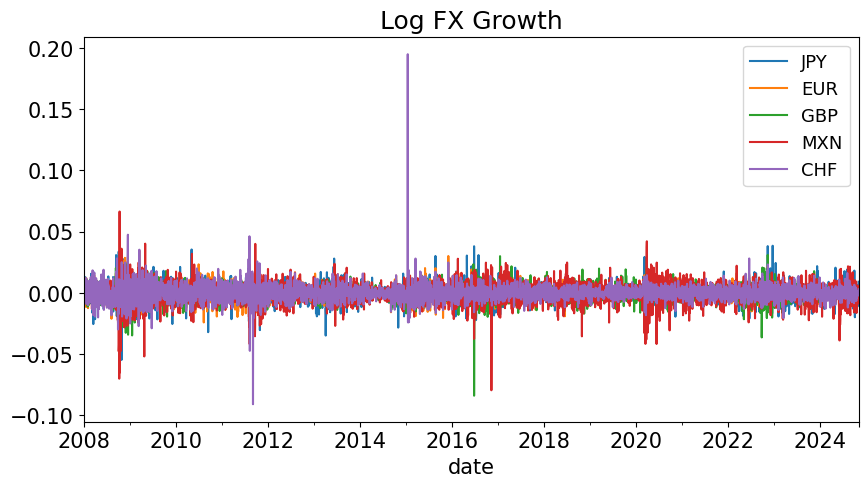

In [13]:
logFXgrowth.plot(title='Log FX Growth', figsize=(10,5));

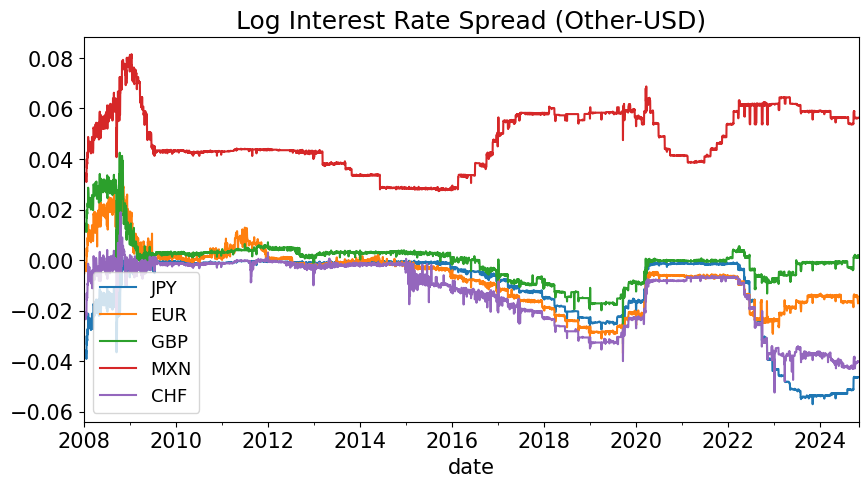

In [14]:
(-logRFspread*DAYS).plot(title='Log Interest Rate Spread (Other-USD)', figsize=(10,5));

In [15]:
rx_components = logFXgrowth.mean().to_frame()
rx_components.columns=['FX effect']
rx_components['RF effect'] = -logRFspread.mean().values
rx_components['Total'] = rx_components.sum(axis=1)
rx_components *= DAYS
rx_components.style.format('{:.2%}')

,FX effect,RF effect,Total
JPY,-1.83%,-1.18%,-3.02%
EUR,-1.74%,-0.68%,-2.42%
GBP,-2.57%,-0.01%,-2.57%
MXN,-3.61%,4.79%,1.19%
CHF,1.61%,-1.31%,0.30%


***

# Rate Carry

## Yields

### Current Yield Curve

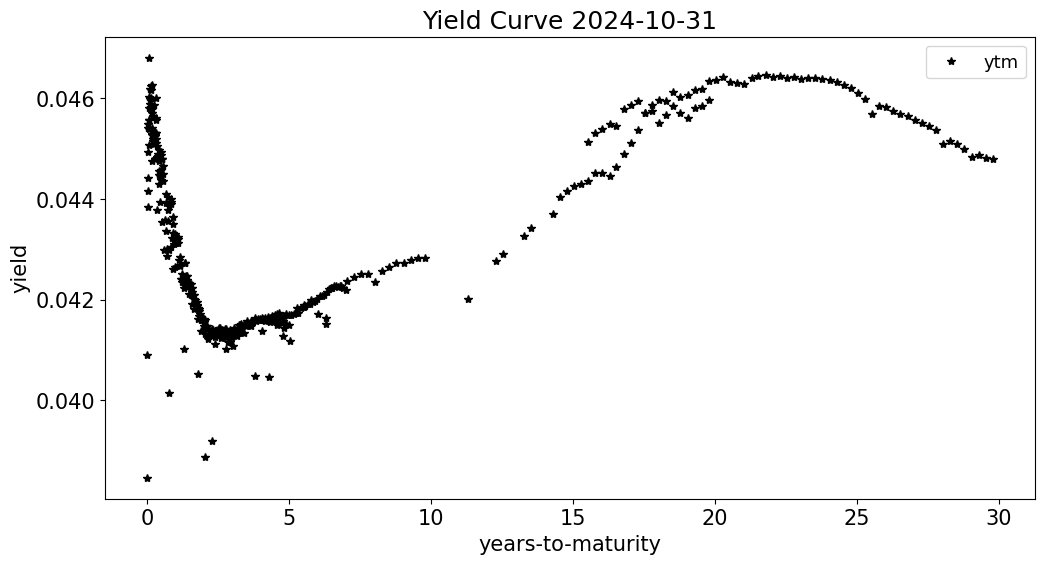

In [16]:
DATEIN = '2024-10-31'
FILEIN = f'../data/treasury_quotes_{DATEIN}.xlsx'
data = pd.read_excel(FILEIN,sheet_name='quotes').set_index('KYTREASNO')

data[['ytm','ttm']].set_index('ttm').plot(linestyle='',marker='*', color='k')
plt.legend()
plt.xlabel('years-to-maturity')
plt.ylabel('yield')
plt.title(f'Yield Curve {DATEIN}')
plt.show()

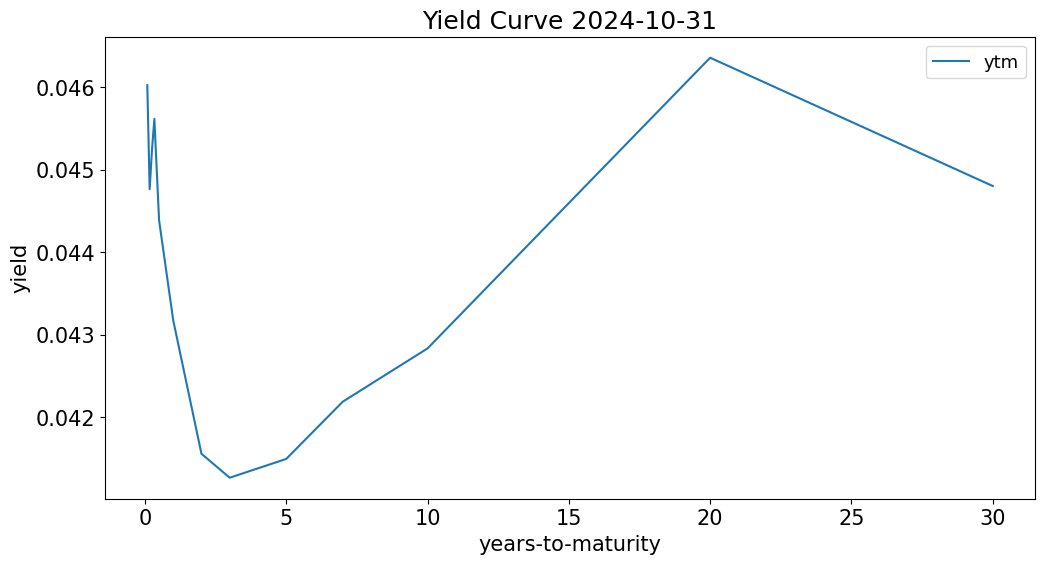

In [17]:
mats = [1/12,2/12,3/12,4/12,6/12,1,2,3,5,7,10,20,30]

ycurve_key = pd.DataFrame(dtype=float,index=mats,columns=['ytm'])
for mat in mats:
    idx = (data['ttm']-mat).abs().idxmin()
    ycurve_key.loc[mat,'ytm'] = data.loc[idx,'ytm']

ycurve_key.plot()

plt.legend()
plt.xlabel('years-to-maturity')
plt.ylabel('yield')
plt.title(f'Yield Curve {DATEIN}')
plt.show()

In [18]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

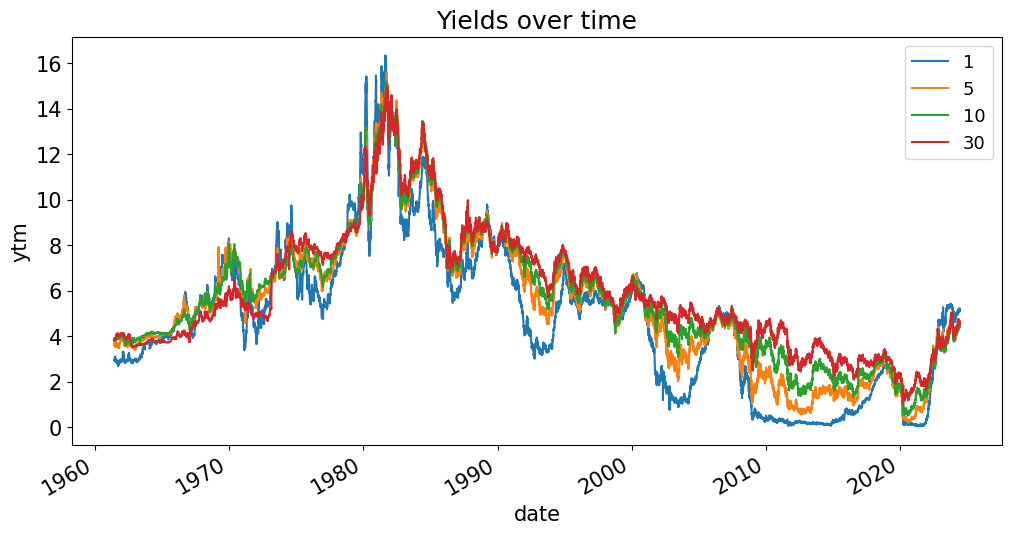

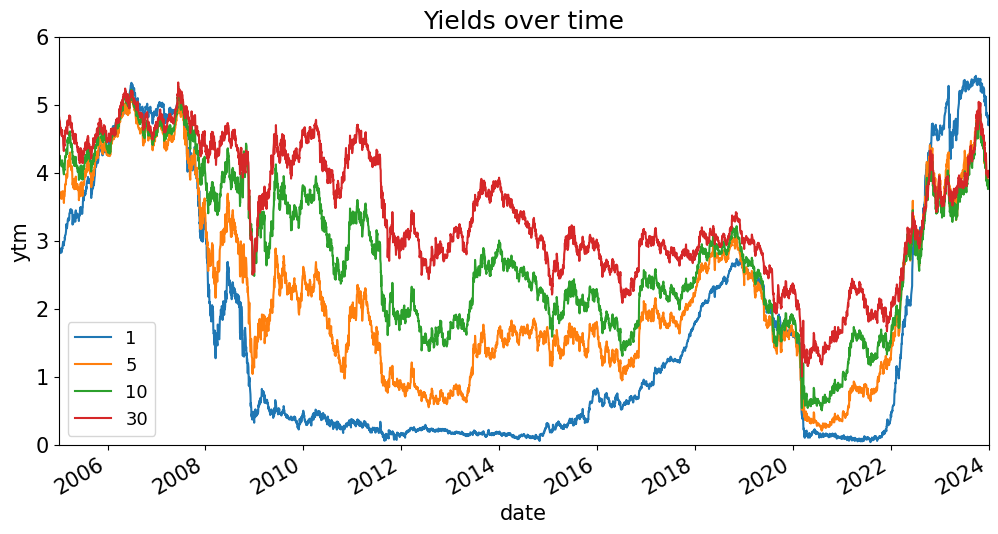

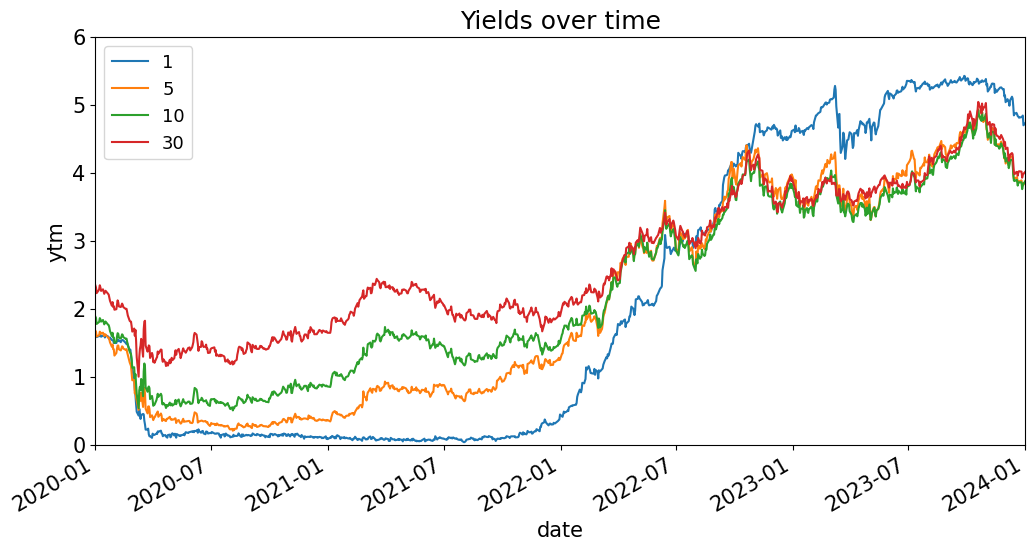

In [19]:
yields[[1,5,10,30]].plot(title='Yields over time',xlabel='date',ylabel='ytm')
yields[[1,5,10,30]].plot(xlim=('2005-01-01','2024-01-01'),ylim=(0,6),title='Yields over time',xlabel='date',ylabel='ytm')
yields[[1,5,10,30]].plot(xlim=('2020-01-01','2024-01-01'),ylim=(0,6),title='Yields over time',xlabel='date',ylabel='ytm')
plt.show()

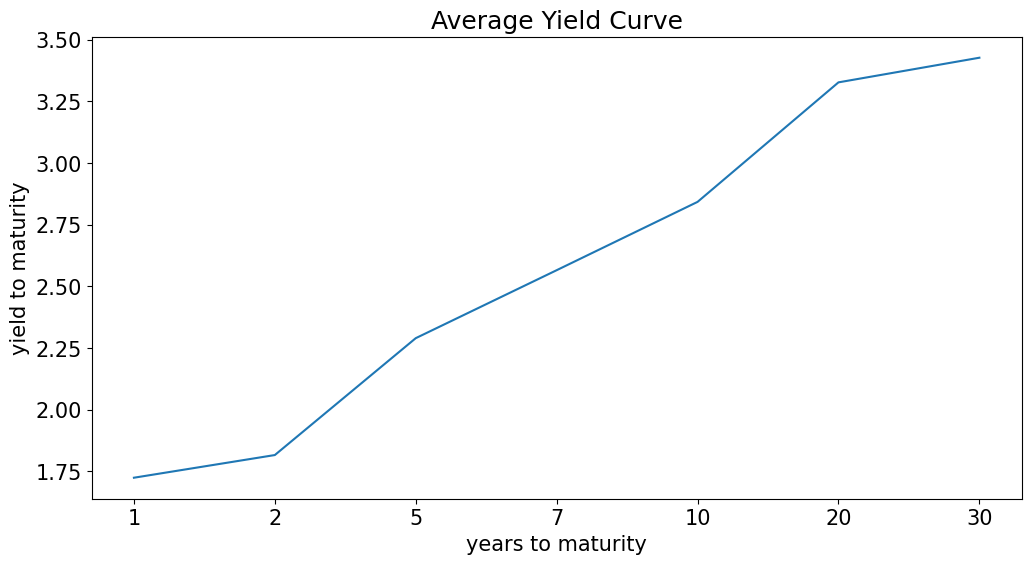

In [21]:
DATETHRESH = '2005-01-01'

yields.loc[DATETHRESH:].mean().plot();
plt.title('Average Yield Curve');
plt.ylabel('yield to maturity');
plt.xlabel('years to maturity');

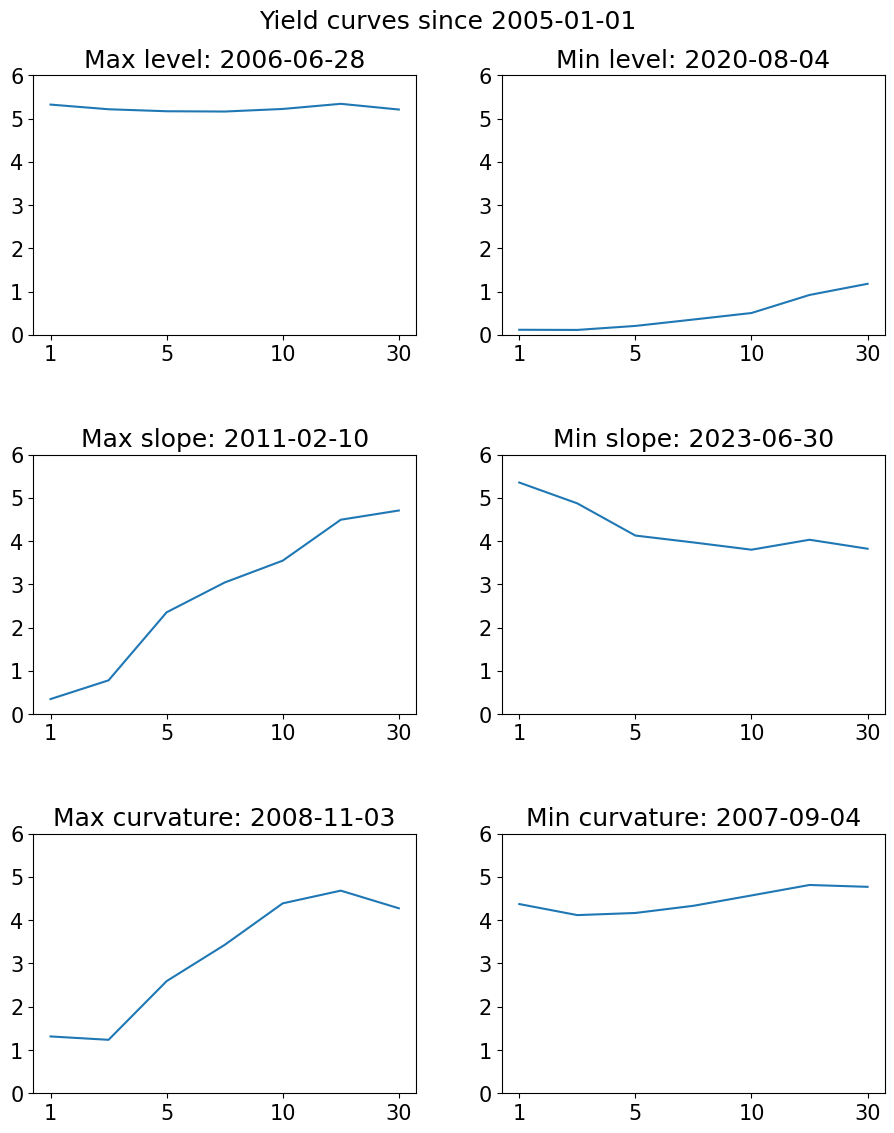

In [ ]:
shapes_all = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes_all['slope'] = yields[30]-yields[1]
shapes_all['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

shapes = shapes_all[shapes_all.index>DATETHRESH]

fig, axs = plt.subplots(3,2,figsize=(10,12))

idx = shapes['level'].idxmax()
lab = f'Max level: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[0,0],title = lab,ylim=(0,6))

idx = shapes['level'].idxmin()
lab = f'Min level: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[0,1],title = lab,ylim=(0,6))

idx = shapes['slope'].idxmax()
lab = f'Max slope: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[1,0],title = lab,ylim=(0,6))

idx = shapes['slope'].idxmin()
lab = f'Min slope: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[1,1],title = lab,ylim=(0,6))

idx = shapes['curvature'].idxmax()
lab = f'Max curvature: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[2,0],title = lab,ylim=(0,6))

idx = shapes['curvature'].abs().idxmin()
lab = f'Min curvature: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[2,1],title = lab,ylim=(0,6))

fig.tight_layout(pad=3.0)
fig.suptitle(f'Yield curves since {DATETHRESH}')
plt.show()

## STRIPS

Consider US Treasury Bonds

We examine data of STRIPS, such that the bond...
* has no credit risk
* normalized to face value of $100
* pays no coupon



### Fact #1: 
#### Long-term yields are higher than short-term yields--even averaged over long periods of time.
This means that long-term yields cannot simply be an average of short-term yields.

In [ ]:
DATAPATH = '../data/famabliss_strips.xlsx'
SHEET = 'prices'
prices = pd.read_excel(DATAPATH,sheet_name=SHEET).set_index('date')/100

lprices = np.log(prices)
lyields = - lprices.copy() / lprices.columns.values.astype('float64')

In [ ]:
EHtest1 = lyields.mean().to_frame().rename(columns={0:'mean yield'})
EHtest1.style.format('{:.2%}')

,mean yield
1,4.55%
2,4.73%
3,4.89%
4,5.03%
5,5.14%


### Fact #2: 
#### Forwards are higher on average than the future yield.

In [ ]:
lforwards = -lprices.diff(axis=1)
lforwards[1] = -lprices[1]
lforwardsx = lforwards.subtract(lforwards[1],axis=0).drop(columns=[1])

In [ ]:
EHtest2 = pd.DataFrame(columns=['$$f_t^{(n, n+1)}$$','$$y_{t+n}^{(1)}$$'],index=lforwards.columns,dtype=float)

for mat in EHtest2.index:
    temp = pd.concat([lforwards[mat].shift(mat), lyields[mat]],axis=1)
    EHtest2.loc[mat,:] = temp.mean().values

EHtest2['forward pred minus obs'] = EHtest2.iloc[:,0]- EHtest2.iloc[:,1]

EHtest2.style.format('{:.2%}')

,"$$f_t^{(n, n+1)}$$",$$y_{t+n}^{(1)}$$,forward pred minus obs
1,4.55%,4.55%,0.00%
2,4.90%,4.73%,0.18%
3,5.23%,4.89%,0.34%
4,5.47%,5.03%,0.44%
5,5.55%,5.14%,0.42%


### Fact #3: 
#### Excess returns are not zero.

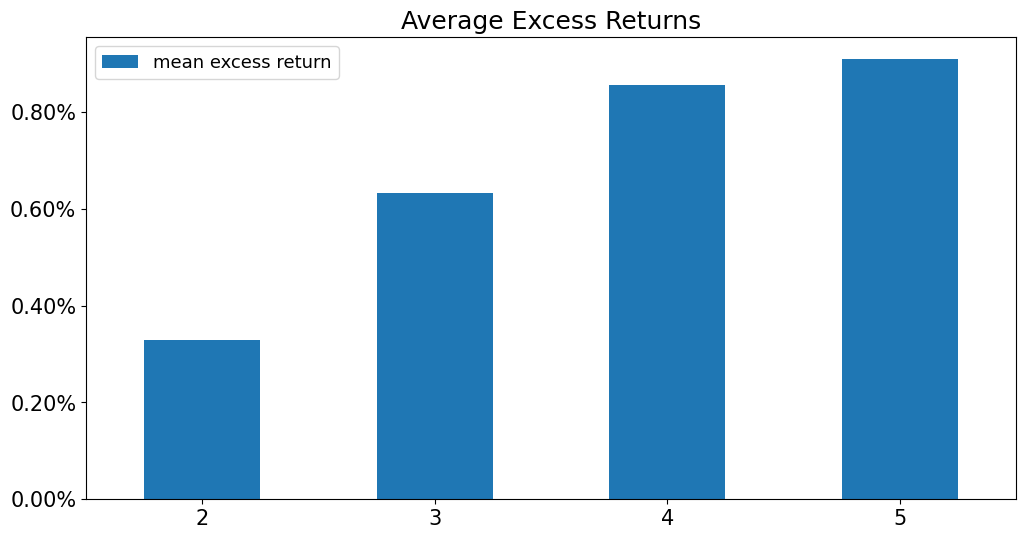

In [ ]:
FREQ = 12

lrets = pd.DataFrame(columns=lprices.columns, index=lprices.index)
lrets.index.name = 'Log Returns'
lrets[1] = lyields[1].shift(FREQ)

for n in range(2,6):
    lrets[n] = lprices[n-1] - lprices[n].shift(FREQ)

lrets.dropna(inplace=True)
lretsx = lrets.subtract(lrets[1],axis=0).drop(columns=[1])

EHtest3 = lretsx.mean().to_frame().rename(columns={0:'mean excess return'})

ax = EHtest3.plot.bar(title='Average Excess Returns')
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.show()

### Conclusion

The statistics above are evidence against the Expectations Hypothesis. 

Specifically,
1. Long-term yields do NOT equal average short-term yields. 
2. Forwards systematically overstate future yields.
3. Long-term bonds have excess returns.

***

# Commodity Carry

In [ ]:
LOADFILE = '../data/futures_data.xlsx'
futures_info = pd.read_excel(LOADFILE,sheet_name='futures contracts').set_index('symbol')

In [ ]:
list_curves = ['CL1','GC1']
curves = dict()
for comdty in list_curves:
    curves[comdty]= pd.read_excel(LOADFILE,sheet_name=f'curve {comdty}')

In [ ]:
curves[comdty].style.format({'price':'${:,.2f}', 'open interest':'{:,.0f}'})

,ticker,delivery date,price,open interest
0,GCN4 Comdty,2024-07-01 00:00:00,"$2,402.40",84
1,GCU4 Comdty,2024-09-03 00:00:00,"$2,417.00","1,146"
2,GCZ4 Comdty,2024-12-02 00:00:00,"$2,451.40","292,232"
3,GCJ5 Comdty,2025-04-01 00:00:00,"$2,496.20","8,191"
4,GCQ5 Comdty,2025-08-01 00:00:00,"$2,523.60",377
5,GCZ5 Comdty,2025-12-01 00:00:00,"$2,558.20","2,648"
6,GCJ6 Comdty,2026-04-01 00:00:00,"$2,593.70",15
7,GCZ6 Comdty,2026-12-01 00:00:00,"$2,657.70",2
8,GCZ7 Comdty,2027-12-01 00:00:00,"$2,699.80",4
9,GCZ8 Comdty,2028-12-01 00:00:00,"$2,731.00",0


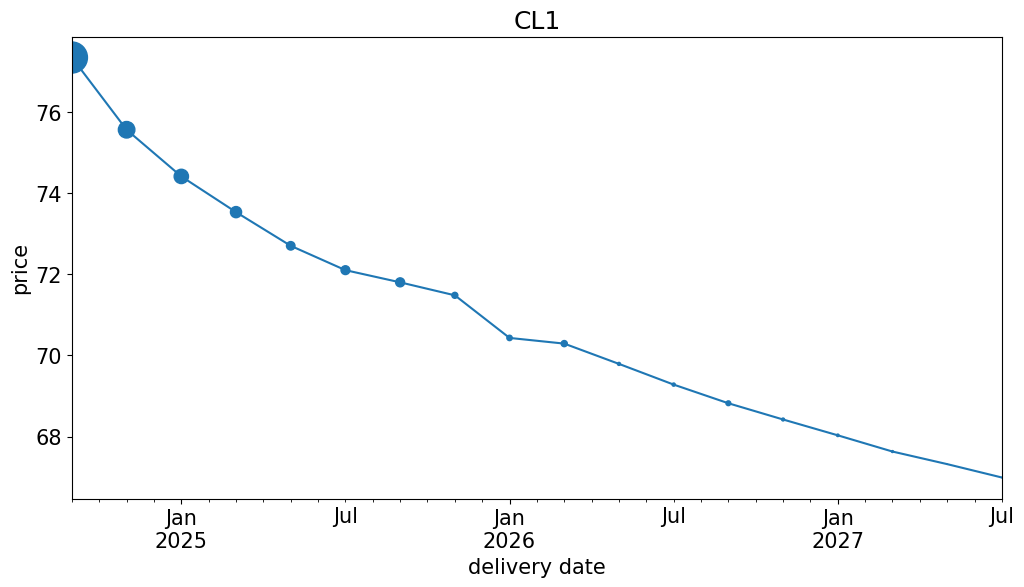

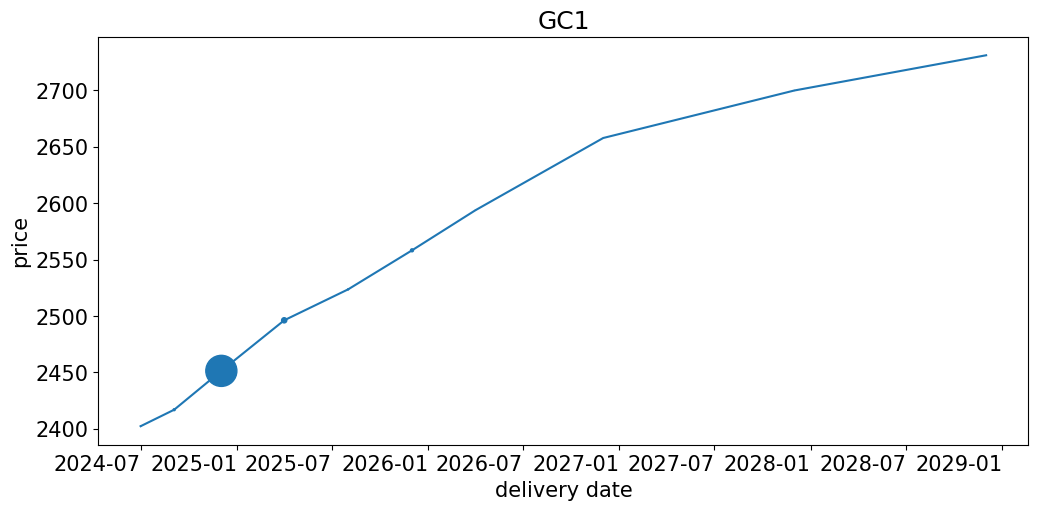

In [ ]:
for comdty in list_curves:
    
    temp = curves[comdty].set_index('delivery date').sort_index()
    msize = (temp['open interest']/temp['open interest'].max()) * 500
    
    fig, ax=plt.subplots()
    temp['price'].plot(ax=ax,marker=None,title=comdty)
    temp.reset_index().plot.scatter('delivery date','price',s=msize,ax=ax,title=comdty)
    plt.show()

In [ ]:
PLOTDATESTART_2 = '2024-04'
PLOTDATEEND = '2024-07-15'

In [ ]:
TICKS = ['CL','GC']

futures_ts = pd.read_excel(LOADFILE,sheet_name='futures timeseries',header=[0,1,2]).droplevel(2,axis=1)
futures_ts.set_index(futures_ts.columns[0],inplace=True)
futures_ts.index.name = 'date'
futures_ts = futures_ts.swaplevel(axis=1)

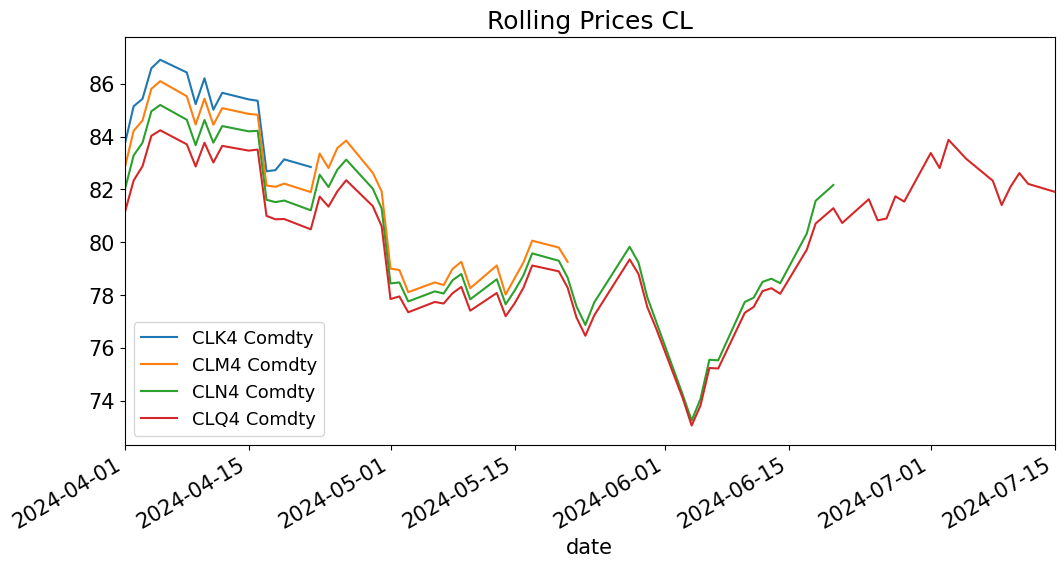

In [ ]:
ptitle = futures_ts['LAST_PRICE'].iloc[:,0].name[:2]
temp = futures_ts['LAST_PRICE'].iloc[:,0:4][PLOTDATESTART_2:PLOTDATEEND]
temp.plot(xlim=(PLOTDATESTART_2,PLOTDATEEND),ylim=(.99*temp.min().min(),1.01*temp.max().max()),title=f'Rolling Prices {ptitle}');

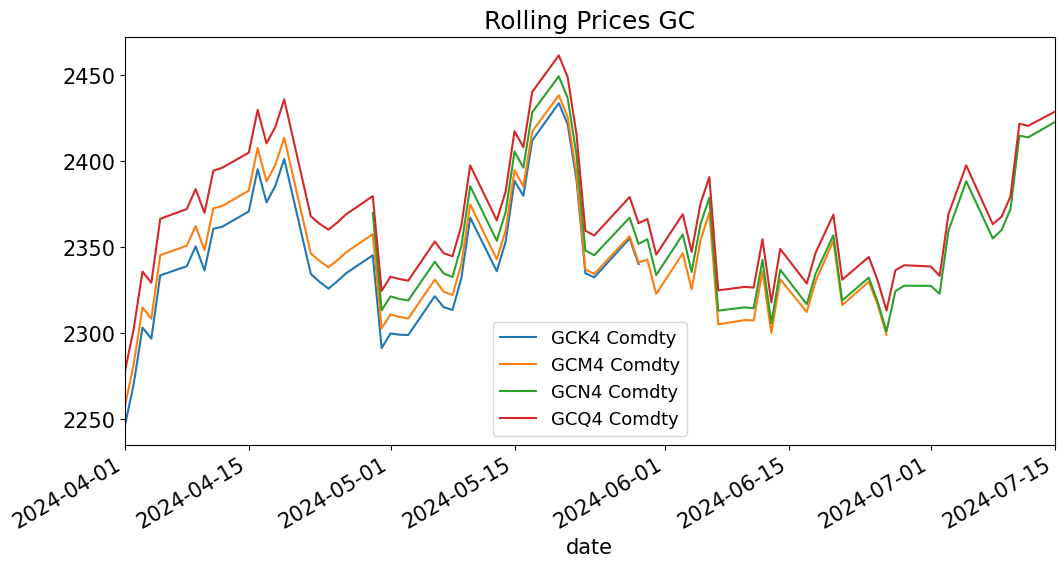

In [ ]:
ptitle = futures_ts['LAST_PRICE'].iloc[:,4].name[:2]
temp = futures_ts['LAST_PRICE'].iloc[:,4:][PLOTDATESTART_2:PLOTDATEEND]
temp.plot(xlim=(PLOTDATESTART_2,PLOTDATEEND),title=f'Rolling Prices {ptitle}');